In [1]:
!pip install yfinance
!pip install yahoofinancials
!pip install ta

In [2]:
# display multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams["lines.linewidth"] = 3.0

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-31,460.382172,461.757629,453.111938,454.733002,449.019958,19091
2011-01-03,454.978638,463.575195,454.782135,462.150604,456.344391,12076
2011-01-04,466.669952,469.519073,456.108459,459.989197,454.210144,12567


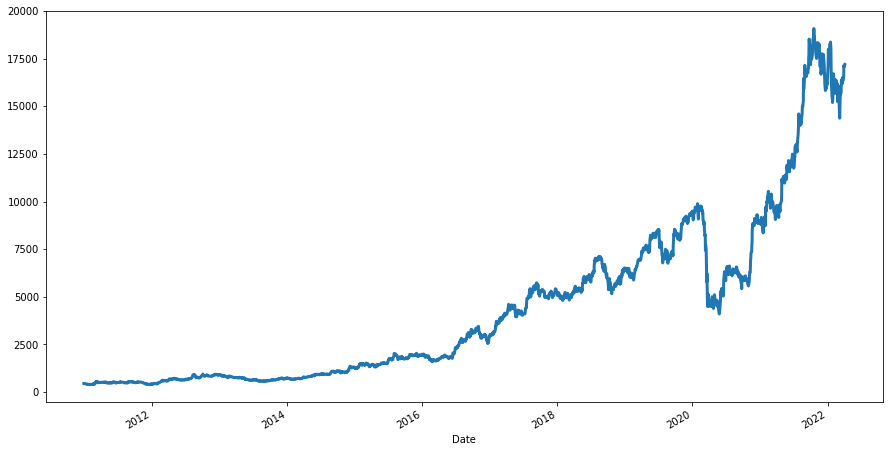

In [5]:
bajajdf = yf.download("BAJAJFINSV.NS", start="2010-12-31", progress=False)
bajajdf.head(3)
print()
bajajdf["Adj Close"].plot()

In [6]:
from ta.trend import SMAIndicator
bajajdf["sma20"] = SMAIndicator(close=bajajdf["Adj Close"], window=20, fillna=True).sma_indicator()
bajajdf["sma50"] = SMAIndicator(close=bajajdf["Adj Close"], window=50, fillna=True).sma_indicator()
bajajdf["signal"] = np.where(bajajdf["sma20"]>bajajdf["sma50"], 1, 0)
bajajdf["signal"] = bajajdf["signal"].shift(1)
bajajdf.dropna(inplace=True)
bajajdf["signal"].describe()

count    2774.000000
mean        0.635905
std         0.481262
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: signal, dtype: float64

In [7]:
bajajdf["ROC"] = np.log(bajajdf["Adj Close"] / bajajdf["Adj Close"].shift(1))
bajajdf["return"] = bajajdf["ROC"]*bajajdf["signal"]
bajajdf["portfolio"] = np.exp(bajajdf["return"].cumsum())
bajajdf.dropna(inplace=True)
bajajdf.tail(3)

,Open,High,Low,Close,Adj Close,Volume,sma20,sma50,signal,ROC,return,portfolio
Date,,,,,,,,,,,,
2022-03-31,17100.0,17300.0,16982.000000,17060.449219,17060.449219,298692,15940.032373,16075.127949,0.0,-0.004004,-0.0,20.23176
2022-04-01,17030.0,17200.0,17011.199219,17139.199219,17139.199219,210141,16011.787354,16054.840918,0.0,0.004605,0.0,20.23176
2022-04-04,17199.0,17480.0,16955.250000,17196.349609,17196.349609,324263,16104.944824,16037.221895,0.0,0.003329,0.0,20.23176


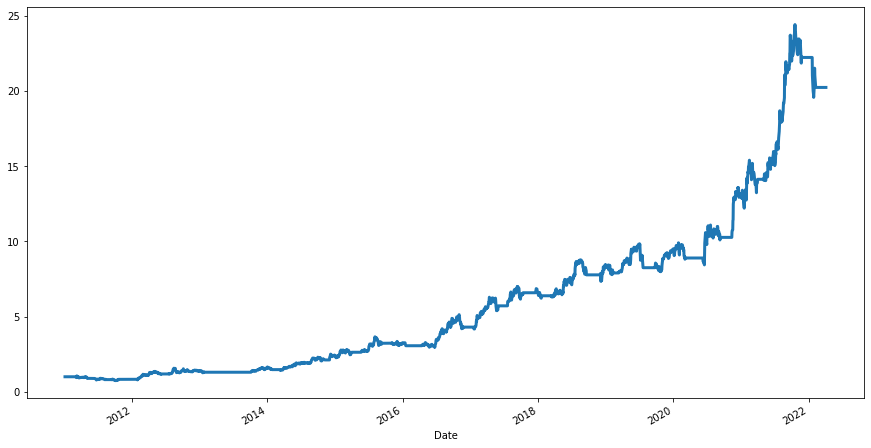

In [8]:
bajajdf["portfolio"].plot()

In [9]:
duration_days = bajajdf.index.max()-bajajdf.index.min()
duration_years = duration_days.days/365.25
duration_in_trade = duration_years * bajajdf["signal"].mean()
print(f"duration in trade: {duration_in_trade:.4f}")

net_avg_return = bajajdf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
print(f"net average return: {net_avg_return:.4f}")

returns = bajajdf[bajajdf["return"]!=0]["return"]
sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))
print(f"sharpe ratio: {sharpe_ratio:.4f}")

duration in trade: 7.1547
net average return: 0.5225
sharpe ratio: 1.2131


In [10]:
from ta.trend import SMAIndicator
import copy

iilist = []
jjlist = []
narlist = []
srlist = []

df = yf.download("BAJAJFINSV.NS", start="2010-12-31", progress=False)

for ii in range(10, 295, 5):
  for jj in range(ii+5, 300, 5):
    bajajdf = copy.deepcopy(df)
    bajajdf["sma1"] = SMAIndicator(close=bajajdf["Adj Close"], window=ii, fillna=True).sma_indicator()
    bajajdf["sma2"] = SMAIndicator(close=bajajdf["Adj Close"], window=jj, fillna=True).sma_indicator()
    bajajdf["signal"] = np.where(bajajdf["sma1"]>bajajdf["sma2"], 1, 0)
    bajajdf["signal"] = bajajdf["signal"].shift(1)
    bajajdf.dropna(inplace=True)
    bajajdf["ROC"] = np.log(bajajdf["Adj Close"] / bajajdf["Adj Close"].shift(1))
    bajajdf["return"] = bajajdf["ROC"]*bajajdf["signal"]
    bajajdf["portfolio"] = np.exp(bajajdf["return"].cumsum())
    bajajdf.dropna(inplace=True)
    duration_days = bajajdf.index.max()-bajajdf.index.min()
    duration_years = duration_days.days/365.25
    duration_in_trade = duration_years * bajajdf["signal"].mean()

    if (duration_in_trade!=0):
      net_avg_return = bajajdf.iloc[-1]["portfolio"]**(1/duration_in_trade)-1
      returns = bajajdf[bajajdf["return"]!=0]["return"]
      sharpe_ratio = (returns.mean()*250 - 0.0384)/(returns.std()*np.sqrt(250))

    iilist.append(ii)
    jjlist.append(jj)
    narlist.append(net_avg_return)
    srlist.append(sharpe_ratio)

In [11]:
# net average return based
print(f"sma1: {iilist[np.argmax(narlist)]}")
print(f"sma2: {jjlist[np.argmax(narlist)]}")

sma1: 30
sma2: 40


In [12]:
# sharpe ratio based
print(f"sma1: {iilist[np.argmax(srlist)]}")
print(f"sma2: {jjlist[np.argmax(srlist)]}")

sma1: 30
sma2: 40


In [13]:
resultdf = pd.DataFrame(np.column_stack([iilist, jjlist, narlist, srlist]), columns=["sma1", "sma2", "nar", "sr"])

In [14]:
resultdf[(resultdf["sma1"]==30) & (resultdf["sma2"]==40)]

,sma1,sma2,nar,sr
223,30.0,40.0,0.705828,1.591524
